<a href="https://colab.research.google.com/github/MariaBlancoGonzalez/Machine-Learning-22/blob/main/notebooks/NLP_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP COMMENTS ASSIGNMENT

This work has been carried out by:


*   María Blanco González-Mohíno
*   Pablo Velasco Crespo
*   José Alberto Seco Sánchez-Camacho
*   Adrián Ruíz Esteban

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load


In [53]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

import numpy as np
from math import ceil
import pandas as pd

from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [67]:
!wget https://github.com/MariaBlancoGonzalez/Machine-Learning-22/raw/main/data/processed/comments.pkl

--2022-01-21 19:32:24--  https://github.com/MariaBlancoGonzalez/Machine-Learning-22/raw/main/data/processed/comments.pkl
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MariaBlancoGonzalez/Machine-Learning-22/main/data/processed/comments.pkl [following]
--2022-01-21 19:32:24--  https://raw.githubusercontent.com/MariaBlancoGonzalez/Machine-Learning-22/main/data/processed/comments.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1692288 (1.6M) [application/octet-stream]
Saving to: ‘comments.pkl’

comments.pkl        100%[===================>]   1.61M  --.-KB/s    in 0.06s   

2022-01-21 19:32:2

In [68]:
comments = pd.read_pickle('comments.pkl')
comments.head(2)

# Failing that, use:
# comments = pd.read_pickle('/content/drive/MyDrive/Machine_Learning/df_tfidf.pkl')
# comments.head(2)

,class,text
0,Auto,I have recently purchased a J30T with moderat...
1,Camera,I bought this product because I need instant ...


In [ ]:
df_tfidf = pd.read_pickle('/content/drive/MyDrive/Machine_Learning/df_tfidf.pkl')
df_tfidf.head(2)

,00,000,01,02,024,03,03cm,04,048,05,050,06,07,07280001,075,08,09,0f,0l,0litre,0m,0x,10,100,1000,1000f,1000fn,1000ma,1000mb,1000th,100cs,100k,100lbs,100mph,102,1024,1024x768,102769987204,102mm,103,...,young,younger,your,yourself,youth,youthful,yr,yugo,yup,yuppie,z1,z3,z3m,z66,z71,zagging,zdnet,zealand,zeiss,zero,zeroed,ziebart,zig,zillion,zing,zip,zipp,zippier,zippiness,zippy,zj,zone,zoo,zoom,zoombrowser,zoomed,zoomey,zooming,zx2,zx3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.164229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_ngrams = pd.read_pickle('/content/drive/MyDrive/Machine_Learning/df_ngrams.pkl')
df_ngrams.head(2)

,00,00 00,00 00 from,00 649,00 649 00,00 95,00 95 from,00 after,00 after bringing,00 and,00 and 100,00 and headed,00 and it,00 and wa,00 bottom,00 bottom line,00 but,00 but believe,00 but since,00 cad,00 cad the,00 camera,00 camera in,00 canon,00 canon powershot,00 clearance,00 clearance to,00 digital,00 digital camera,00 for,00 for it,00 for the,00 for this,00 from,00 from brandenburkhart,00 from www,00 give,00 give or,00 here,00 here my,...,zoomey camera cropping,zooming,zooming ability,zooming ability of,zooming after,zooming after you,zooming capability,zooming capability of,zooming etc,zooming etc very,zooming finder,zooming finder and,zooming flash,zooming flash head,zooming in,zooming in and,zooming in film,zooming in from,zooming in on,zooming in the,zooming need,zooming need not,zooming optical,zooming optical now,zooming ratio,zooming ratio with,zooming will,zooming will undermine,zx2,zx2 because,zx2 because of,zx2 bought,zx2 bought my,zx2 for,zx2 for single,zx2 new,zx2 new after,zx3,zx3 where,zx3 where lauded
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_ngrams_pos = pd.read_pickle('/content/drive/MyDrive/Machine_Learning/df_ngrams_pos.pkl')
df_ngrams_pos.head(2)

,00,00 cd,00 cd 649,00 cd after,00 cd and,00 cd bottom,00 cd but,00 cd cad,00 cd camera,00 cd canon,00 cd cd,00 cd clearance,00 cd digital,00 cd dt,00 cd for,00 cd from,00 cd give,00 cd here,00 cd if,00 cd in,00 cd it,00 cd just,00 cd last,00 cd le,00 cd looking,00 cd making,00 cd new,00 cd nn,00 cd now,00 cd occasional,00 cd online,00 cd per,00 cd personal,00 cd photoshop,00 cd plus,00 cd pm,00 cd pny,00 cd sample,00 cd street,00 cd that,...,zoombrowser nnp,zoombrowser nnp ex,zoomed,zoomed nnp,zoomed nnp pixel,zoomed vbd,zoomed vbd into,zoomed vbn,zoomed vbn forward,zoomed vbn in,zoomed vbn out,zoomey,zoomey nn,zoomey nn camera,zooming,zooming nn,zooming nn ability,zooming nn after,zooming nn capability,zooming nn flash,zooming nn in,zooming nn will,zooming vbg,zooming vbg ability,zooming vbg etc,zooming vbg finder,zooming vbg in,zooming vbg need,zooming vbg optical,zooming vbg ratio,zx2,zx2 nn,zx2 nn because,zx2 nn for,zx2 nn nn,zx2 vbd,zx2 vbd new,zx3,zx3 nn,zx3 nn where
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model

Here we compute some metrics in order to make more understandable the prediction that we obtain in each one of the SVM classification algorithm.

Here is an image that shows the confusion matrix very well:

![confusionmatrix.png](https://miro.medium.com/max/625/1*y4HwoAEgx1Js19hCkPM7XA.png)

In [57]:
def metrics(tn,fp,fn,tp):
  p = tp + fn
  n = fp+tn
  precission = tp/(tp+fp)
  print("Precision: ",precission)
  recall = tp/p
  print("Recall: ", recall)
  accuracy = (tp+tn)/(p+n)
  print("Accuracy: ", accuracy)
  false_positive_rate = fp/(n)
  print("False positive rate: ",false_positive_rate)
  f_measure = 2/((1/precission)+(1/recall))
  print("F-measure: ",f_measure)

## TFIDF

### Feature selection

In [ ]:
X_clf = df_tfidf

y_clf = comments['class']

y_clf = np.where(y_clf == 'Auto', 0, y_clf)
y_clf = np.where(y_clf == 'Camera', 1, y_clf)
y_clf = y_clf.astype('int')

y_clf

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,

K-best selection

In [ ]:
lenght = len(X_clf.columns)
rest_pertcentage = ceil(0.7*len(X_clf.columns))
th_percentage = lenght - rest_pertcentage
print('100% of features: {}\n 70% of features: {}'.format(lenght, rest_pertcentage))

100% of features: 11736
 70% of features: 8216


In [ ]:
X_clf_kBest=SelectKBest(score_func=chi2,k=th_percentage).fit_transform(X_clf,y_clf)
X_clf_kBest

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_clf_kBest.shape

(600, 3520)

### Classification algorithm: SVM

Support Vector Machine are a set of supervised learning algorithms developed by Vladimir Vapnik.

In [ ]:
X_clf_train = pd.DataFrame(X_clf_kBest)
X_clf_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3480,3481,3482,3483,3484,3485,3486,3487,3488,3489,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507,3508,3509,3510,3511,3512,3513,3514,3515,3516,3517,3518,3519
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067087,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.293617,0.164229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = X_clf_train[list(X_clf_train.columns)]
y = pd.Series(y_clf)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.32)

In [ ]:
parameters = {'kernel':('linear','rbf')}

svc = svm.SVC(gamma='auto') # 1/features

clf = GridSearchCV(svc, parameters, cv=3)
results = clf.fit(X_train, y_train)
results

GridSearchCV(cv=3, estimator=SVC(gamma='auto'),
             param_grid={'kernel': ('linear', 'rbf')})

In [ ]:
print(results.best_score_, results.best_params_)

1.0 {'kernel': 'linear'}


In [ ]:
y_pred = results.predict(X_test)

In [ ]:
tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
metrics(tn,fp,fn,tp)

77 0 0 115
Precision:  1.0
Recall:  1.0
Accuracy:  1.0
False positive rate:  0.0
F-measure:  1.0


As we can see the prediction is very accurate and there aren't any false positives or false negatives.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


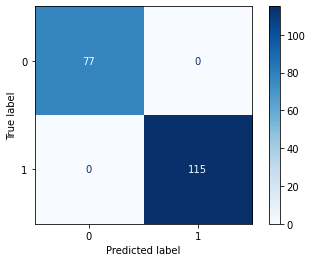

In [ ]:
disp = plot_confusion_matrix(results, X_test, y_test,cmap=plt.cm.Blues) 
plt.show()

### Classification option 2: Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=512, n_jobs=-1)

In [ ]:
param_dist = {"max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": [8,16,32,64,128], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["gini", "entropy"]}

In [ ]:
random_search = RandomizedSearchCV(clf,  
                                   param_distributions=param_dist, 
                                   n_iter= 20, cv=3)
                                   

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_estimators=512,
                                                    n_jobs=-1),
                   n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [8, 16, 32, 64, 128],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe35802b890>})

In [ ]:
def report(results, n_top=2): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 32, 'max_features': 'auto', 'min_samples_split': 33}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 64, 'max_features': 'sqrt', 'min_samples_split': 8}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 42}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 64, 'max_features': 'sqrt', 'min_samples_split': 42}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': Fals

In [ ]:
clf_rf = RandomForestClassifier(n_estimators = 512, criterion = 'gini', 
                                max_depth=2, max_features = 'auto', 
                                min_samples_leaf = 17, min_samples_split = 30,
                                bootstrap=False
                                )

clf_rf.fit(X_train, y_train) # Construcción del modelo

preds_rf = clf_rf.predict(X_test) # Test del modelo

In [ ]:
from sklearn.metrics import classification_report

print("Random Forest: \n" 
      +classification_report(y_true=y_test, y_pred=preds_rf))

# Confussion Matrix

print("Confussion Matrixn:\n")
matriz = pd.crosstab(y_test, preds_rf, rownames=['actual'], colnames=['preds'])
print(matriz)

# Variables relevantes

print("Feature Relevance:\n")
print(pd.DataFrame({'Feature': X_train.columns ,
              'Relevancy': clf_rf.feature_importances_}),"\n")
print("Maximum relevance RF :" , max(clf_rf.feature_importances_), "\n")

Random Forest: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00       115

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192

Confussion Matrixn:

preds    0    1
actual         
0       77    0
1        0  115
Feature Relevance:

      Feature  Relevancy
0           0   0.000000
1           1   0.013260
2           2   0.000000
3           3   0.000000
4           4   0.000000
...       ...        ...
3515     3515   0.027934
3516     3516   0.000000
3517     3517   0.000000
3518     3518   0.000000
3519     3519   0.000000

[3520 rows x 2 columns] 

Maximum relevance RF : 0.03958650284255426 



As we can see this prediction is also pretty accurate and there aren't any false negatives or false positives.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


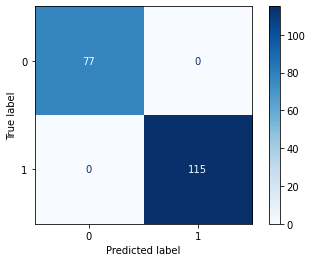

In [ ]:
disp = plot_confusion_matrix(clf_rf, X_test, y_test,cmap=plt.cm.Blues) 
plt.show()

## TFIDF - N-grams

### Feature selection

In [ ]:
X_clf = df_ngrams

y_clf = comments['class']

y_clf = np.where(y_clf == 'Auto', 0, y_clf)
y_clf = np.where(y_clf == 'Camera', 1, y_clf)
y_clf = y_clf.astype('int')

X_clf 

,00,00 00,00 00 from,00 649,00 649 00,00 95,00 95 from,00 after,00 after bringing,00 and,00 and 100,00 and headed,00 and it,00 and wa,00 bottom,00 bottom line,00 but,00 but believe,00 but since,00 cad,00 cad the,00 camera,00 camera in,00 canon,00 canon powershot,00 clearance,00 clearance to,00 digital,00 digital camera,00 for,00 for it,00 for the,00 for this,00 from,00 from brandenburkhart,00 from www,00 give,00 give or,00 here,00 here my,...,zoomey camera cropping,zooming,zooming ability,zooming ability of,zooming after,zooming after you,zooming capability,zooming capability of,zooming etc,zooming etc very,zooming finder,zooming finder and,zooming flash,zooming flash head,zooming in,zooming in and,zooming in film,zooming in from,zooming in on,zooming in the,zooming need,zooming need not,zooming optical,zooming optical now,zooming ratio,zooming ratio with,zooming will,zooming will undermine,zx2,zx2 because,zx2 because of,zx2 bought,zx2 bought my,zx2 for,zx2 for single,zx2 new,zx2 new after,zx3,zx3 where,zx3 where lauded
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.024677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037985,0.0,0.0,0.043997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
lenght = len(X_clf.columns)
rest_pertcentage = ceil(0.7*len(X_clf.columns))
th_percentage = lenght - rest_pertcentage
print('100% of features: {}\n 70% of features: {}'.format(lenght, rest_pertcentage))

100% of features: 365891
 70% of features: 256124


In [ ]:
X_clf_kBest=SelectKBest(score_func=chi2,k=th_percentage).fit_transform(X_clf,y_clf)
X_clf_kBest

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_clf_kBest.shape

(600, 109767)

### Classification algorithm: SVM

In [ ]:
X_clf_train = pd.DataFrame(X_clf_kBest)
X_clf_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,109727,109728,109729,109730,109731,109732,109733,109734,109735,109736,109737,109738,109739,109740,109741,109742,109743,109744,109745,109746,109747,109748,109749,109750,109751,109752,109753,109754,109755,109756,109757,109758,109759,109760,109761,109762,109763,109764,109765,109766
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = X_clf_train[list(X_clf_train.columns)]
y = pd.Series(y_clf)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.32)

In [ ]:
parameters = {'kernel':('linear','rbf')}

svc = svm.SVC(gamma='auto')

clf = GridSearchCV(svc, param_grid=parameters, cv=3)
results = clf.fit(X_train, y_train)
results

GridSearchCV(cv=3, estimator=SVC(gamma='auto'),
             param_grid={'kernel': ('linear', 'rbf')})

In [ ]:
print(results.best_score_, results.best_params_)

1.0 {'kernel': 'linear'}


In [ ]:
y_pred = results.predict(X_test)

In [ ]:

tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
metrics(tn,fp,fn,tp)

77 0 0 115
Precision:  1.0
Recall:  1.0
Accuracy:  1.0
False positive rate:  0.0
F-measure:  1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


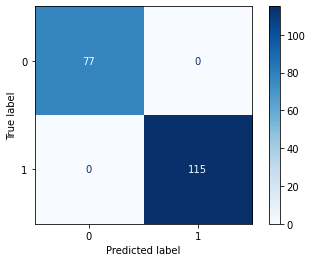

In [ ]:
disp = plot_confusion_matrix(results, X_test, y_test,cmap=plt.cm.Blues) 
plt.show()

### Classification option 2: Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=512, n_jobs=-1)

In [ ]:
param_dist = {"max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": [8,16,32,64,128], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["gini", "entropy"]}

In [ ]:
random_search = RandomizedSearchCV(clf,  
                                   param_distributions=param_dist, 
                                   n_iter= 20, cv=3)
                                   

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_estimators=512,
                                                    n_jobs=-1),
                   n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [8, 16, 32, 64, 128],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe35bee6610>})

In [ ]:
def report(results, n_top=2): # Function to show results
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 16}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 64, 'max_features': 'auto', 'min_samples_split': 45}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 32, 'max_features': 'auto', 'min_samples_split': 46}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 27}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 128, 'max_features': 'auto', 'min_samples_split': 27}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstr

In [ ]:
clf_rf = RandomForestClassifier(n_estimators = 512, criterion = 'gini', 
                                max_depth=32, max_features = 'auto', 
                               min_samples_split = 37,
                                bootstrap=False
                                )

clf_rf.fit(X_train, y_train) # Construcción del modelo

preds_rf = clf_rf.predict(X_test) # Test del modelo

In [ ]:
from sklearn.metrics import classification_report

print("Random Forest: \n" 
      +classification_report(y_true=y_test, y_pred=preds_rf))

# Confussion Matrix

print("Confussion Matrixn:\n")
matriz = pd.crosstab(y_test, preds_rf, rownames=['actual'], colnames=['preds'])
print(matriz)

# Variables relevantes

print("Feature Relevance:\n")
print(pd.DataFrame({'Feature': X_train.columns ,
              'Relevancy': clf_rf.feature_importances_}),"\n")
print("Maximum relevance RF :" , max(clf_rf.feature_importances_), "\n")

Random Forest: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00       115

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192

Confussion Matrixn:

preds    0    1
actual         
0       77    0
1        0  115
Feature Relevance:

        Feature  Relevancy
0             0   0.000258
1             1   0.000000
2             2   0.000000
3             3   0.000000
4             4   0.000000
...         ...        ...
109762   109762   0.000000
109763   109763   0.000000
109764   109764   0.000000
109765   109765   0.000017
109766   109766   0.000000

[109767 rows x 2 columns] 

Maximum relevance RF : 0.0243214303902241 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


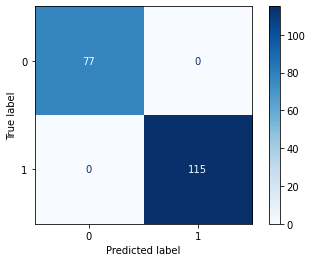

In [ ]:
disp = plot_confusion_matrix(clf_rf, X_test, y_test,cmap=plt.cm.Blues) 
plt.show()

## TFIDF - N-grams - Pos tagging

### Feature selection

In [43]:
X_clf = df_ngrams_pos

y_clf = comments['class']

y_clf = np.where(y_clf == 'Auto', 0, y_clf)
y_clf = np.where(y_clf == 'Camera', 1, y_clf)
y_clf = y_clf.astype('int')

X_clf

,00,00 cd,00 cd 649,00 cd after,00 cd and,00 cd bottom,00 cd but,00 cd cad,00 cd camera,00 cd canon,00 cd cd,00 cd clearance,00 cd digital,00 cd dt,00 cd for,00 cd from,00 cd give,00 cd here,00 cd if,00 cd in,00 cd it,00 cd just,00 cd last,00 cd le,00 cd looking,00 cd making,00 cd new,00 cd nn,00 cd now,00 cd occasional,00 cd online,00 cd per,00 cd personal,00 cd photoshop,00 cd plus,00 cd pm,00 cd pny,00 cd sample,00 cd street,00 cd that,...,zoombrowser nnp,zoombrowser nnp ex,zoomed,zoomed nnp,zoomed nnp pixel,zoomed vbd,zoomed vbd into,zoomed vbn,zoomed vbn forward,zoomed vbn in,zoomed vbn out,zoomey,zoomey nn,zoomey nn camera,zooming,zooming nn,zooming nn ability,zooming nn after,zooming nn capability,zooming nn flash,zooming nn in,zooming nn will,zooming vbg,zooming vbg ability,zooming vbg etc,zooming vbg finder,zooming vbg in,zooming vbg need,zooming vbg optical,zooming vbg ratio,zx2,zx2 nn,zx2 nn because,zx2 nn for,zx2 nn nn,zx2 vbd,zx2 vbd new,zx3,zx3 nn,zx3 nn where
0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.01926,0.01926,0.0,0.0,0.029646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [44]:
lenght = len(X_clf.columns)
rest_pertcentage = ceil(0.7*len(X_clf.columns))
th_percentage = lenght - rest_pertcentage
print('100% of features: {}\n 70% of features: {}'.format(lenght, rest_pertcentage))

100% of features: 242298
 70% of features: 169609


In [45]:
X_clf_kBest=SelectKBest(score_func=chi2,k=th_percentage).fit_transform(X_clf,y_clf)
X_clf_kBest

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
X_clf_kBest.shape

(600, 72689)

### Classification algorithm: SVM

In [47]:
X_clf_train = pd.DataFrame(X_clf_kBest)
X_clf_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,72649,72650,72651,72652,72653,72654,72655,72656,72657,72658,72659,72660,72661,72662,72663,72664,72665,72666,72667,72668,72669,72670,72671,72672,72673,72674,72675,72676,72677,72678,72679,72680,72681,72682,72683,72684,72685,72686,72687,72688
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
X = X_clf_train[list(X_clf_train.columns)]
y = pd.Series(y_clf)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.32)

In [49]:
parameters = {'kernel':('linear','rbf')}

svc = svm.SVC(gamma='auto')

clf = GridSearchCV(svc, param_grid=parameters, cv=3)
results = clf.fit(X_train, y_train)
results

GridSearchCV(cv=3, estimator=SVC(gamma='auto'),
             param_grid={'kernel': ('linear', 'rbf')})

In [50]:
print(results.best_score_, results.best_params_)

1.0 {'kernel': 'linear'}


In [51]:
y_pred = results.predict(X_test)

In [58]:
tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
metrics(tn,fp,fn,tp)

77 0 0 115
Precision:  1.0
Recall:  1.0
Accuracy:  1.0
False positive rate:  0.0
F-measure:  1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


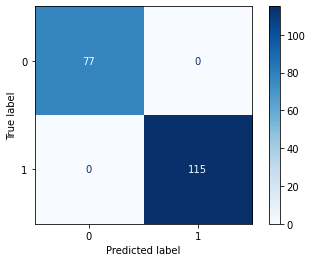

In [59]:
disp = plot_confusion_matrix(results, X_test, y_test,cmap=plt.cm.Blues) 
plt.show()

### Classification option 2: Random Forest

In [60]:
clf = RandomForestClassifier(n_estimators=512, n_jobs=-1)

In [61]:
param_dist = {"max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": [8,16,32,64,128], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["gini", "entropy"]}

In [62]:
random_search = RandomizedSearchCV(clf,  
                                   param_distributions=param_dist, 
                                   n_iter= 20, cv=3)
                                   

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_estimators=512,
                                                    n_jobs=-1),
                   n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [8, 16, 32, 64, 128],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6df80ffcd0>})

In [63]:
def report(results, n_top=2): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 32, 'max_features': 'auto', 'min_samples_split': 11}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 32, 'max_features': 'auto', 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 128, 'max_features': 'auto', 'min_samples_split': 31}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 31}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 128, 'max_features': 'auto', 'min_samples_split': 23}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'bootstrap':

In [64]:
clf_rf = RandomForestClassifier(n_estimators = 512, criterion = 'entropy', 
                                max_depth=128, max_features = 'auto', 
                                min_samples_split = 35,
                                bootstrap=True
                                )

clf_rf.fit(X_train, y_train) # Construcción del modelo

preds_rf = clf_rf.predict(X_test) # Test del modelo

In [65]:
from sklearn.metrics import classification_report

print("Random Forest: \n" 
      +classification_report(y_true=y_test, y_pred=preds_rf))

# Confussion Matrix

print("Confussion Matrixn:\n")
matriz = pd.crosstab(y_test, preds_rf, rownames=['actual'], colnames=['preds'])
print(matriz)

# Variables relevantes

print("Feature Relevance:\n")
print(pd.DataFrame({'Feature': X_train.columns ,
              'Relevancy': clf_rf.feature_importances_}),"\n")
print("Maximum relevance RF :" , max(clf_rf.feature_importances_), "\n")

Random Forest: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00       115

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192

Confussion Matrixn:

preds    0    1
actual         
0       77    0
1        0  115
Feature Relevance:

       Feature  Relevancy
0            0   0.000000
1            1   0.000087
2            2   0.000000
3            3   0.000000
4            4   0.000000
...        ...        ...
72684    72684   0.000000
72685    72685   0.000000
72686    72686   0.000000
72687    72687   0.000000
72688    72688   0.000000

[72689 rows x 2 columns] 

Maximum relevance RF : 0.017726590688462798 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


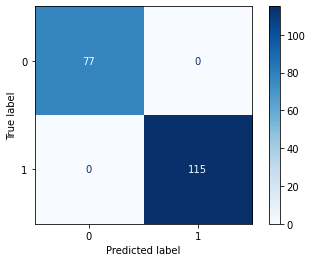

In [66]:
disp = plot_confusion_matrix(clf_rf, X_test, y_test,cmap=plt.cm.Blues) 
plt.show()